# <font color="#4287f5">Classification of Tweets from Northern Europe</font>

**Team Members**
- Jake Brehm
- Tessa Charles

## Importing modules and other setup

In [1]:
import html
import math
import re
import string
from collections import Counter
from time import time
from typing import Optional

import emoji
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tabulate import tabulate

In [2]:
nltk.download("averaged_perceptron_tagger")
nltk.download("omw-1.4")
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
INPUT_PATH = r"/kaggle/input/data-science-capstone-spring-2023"
OUTPUT_PATH = r"/kaggle/working"

# Part I: Descriptive Analysis

## Importing the training dataset

In [4]:
path = "training_data.xlsx"
training_df = pd.read_excel(f"{INPUT_PATH}/{path}")
training_df.head()

,hashtags,full_text,in_reply_to_screen_name,country_user,gender_user,pol_spec_user
0,feminist AskMeAnything,b'RT @swedennewyork: What does it mean to have...,NaN,sweden,Male,Left
1,NaN,b'Jens Stoltenberg \xc3\xa5pnet virtuelle Rock...,NaN,norway,Male,Left
2,NaN,b'@Panenka_Bart Veel beterschap Bart en Loes! ...,BartDerwael,belgium,Male,Left
3,NaN,b'RT @CarlEmilLind: Tydelige S aftryk: \n\nPsk...,NaN,denmark,Female,Left
4,NaN,b'\xf0\x9f\x98\x83 https://t.co/bpqoZ8Y4wm',NaN,sweden,Male,Left


In [5]:
training_df.describe()

,hashtags,full_text,in_reply_to_screen_name,country_user,gender_user,pol_spec_user
count,127040,407223,76747,407223,407223,407223
unique,64254,403715,25869,7,2,4
top,dkpol,b'RT @ECDC_EU: Updated \xf0\x9f\x9a\xa6 maps a...,kvanbrempt,belgium,Male,Left
freq,8239,12,492,91084,269821,174576


## Data preprocessing

### Initial setup and tweaks

First, we must cast the column to their appropriate datatypes so that we can use the proper operations on them.

In [6]:
training_df["hashtags"] = training_df["hashtags"].astype("string")
training_df["full_text"] = training_df["full_text"].astype("string")
training_df.dtypes

hashtags                   string
full_text                  string
in_reply_to_screen_name    object
country_user               object
gender_user                object
pol_spec_user              object
dtype: object

### Data imputation

Each column contains information that requires different methods of imputation.

In this particular scenario, replacing the null values in the *hashtags* column with empty strings is sufficient.

The other columns will be left alone, as either the column contains no missing values or it may be desirable to leave null values in the column.

In [7]:
training_df["hashtags"] = training_df["hashtags"].replace(np.nan, "", regex=True)

### Data exploration

Next, we will make new columns containing information about the number of characters and words in each hashtag and tweet using `count_words` and `count_characters`.

In [8]:
def count_words(string: Optional[str]) -> int:
    """Returns the number of words in the string."""

    # If the input is null or falsy
    if pd.isnull(string) or not string:
        return 0
    # Otherwise, split by space and return the length of the list
    return len(string.split(' '))

In [9]:
def count_characters(string: str, with_spaces: bool=True) -> int:
    """Returns the number of characters in the string.
    
    Also provides the ability to remove spaces.
    """

    # Remove spaces if desired
    if not with_spaces:
        string = string.replace(' ', '')
    # Return the number of characters in the string
    return len(string)

In [10]:
training_df["text_words"] = training_df["full_text"].apply(count_words)
training_df["text_chars"] = training_df["full_text"].apply(count_characters)
training_df.head()

,hashtags,full_text,in_reply_to_screen_name,country_user,gender_user,pol_spec_user,text_words,text_chars
0,feminist AskMeAnything,b'RT @swedennewyork: What does it mean to have...,NaN,sweden,Male,Left,25,154
1,,b'Jens Stoltenberg \xc3\xa5pnet virtuelle Rock...,NaN,norway,Male,Left,13,107
2,,b'@Panenka_Bart Veel beterschap Bart en Loes! ...,BartDerwael,belgium,Male,Left,7,63
3,,b'RT @CarlEmilLind: Tydelige S aftryk: \n\nPsk...,NaN,denmark,Female,Left,15,179
4,,b'\xf0\x9f\x98\x83 https://t.co/bpqoZ8Y4wm',NaN,sweden,Male,Left,2,43


In [11]:
training_df["hashtags_words"] = training_df["hashtags"].apply(count_words)
training_df["hashtags_chars"] = training_df["hashtags"].apply(count_characters)
training_df.head()

,hashtags,full_text,in_reply_to_screen_name,country_user,gender_user,pol_spec_user,text_words,text_chars,hashtags_words,hashtags_chars
0,feminist AskMeAnything,b'RT @swedennewyork: What does it mean to have...,NaN,sweden,Male,Left,25,154,2,22
1,,b'Jens Stoltenberg \xc3\xa5pnet virtuelle Rock...,NaN,norway,Male,Left,13,107,0,0
2,,b'@Panenka_Bart Veel beterschap Bart en Loes! ...,BartDerwael,belgium,Male,Left,7,63,0,0
3,,b'RT @CarlEmilLind: Tydelige S aftryk: \n\nPsk...,NaN,denmark,Female,Left,15,179,0,0
4,,b'\xf0\x9f\x98\x83 https://t.co/bpqoZ8Y4wm',NaN,sweden,Male,Left,2,43,0,0


## Data analysis

### Data aggregation

A summary table will be constructed containing aggregate information of the previously mentioned word and character counts.

In [12]:
# Minimum characters and words of tweets
min_tweet_chars = training_df["text_chars"].min()
min_tweet_words = training_df["text_words"].min()
# Maximum characters and words of tweets
max_tweet_chars = training_df["text_chars"].max()
max_tweet_words = training_df["text_words"].max()
# Average characters and words of tweets
ave_tweet_chars = training_df["text_chars"].mean()
ave_tweet_words = training_df["text_words"].mean()
# Median characters and words of tweets
med_tweet_chars = training_df["text_chars"].median()
med_tweet_words = training_df["text_words"].median()

# Minimum characters and words of hashtags
min_hashtag_chars = training_df["hashtags_chars"].min()
min_hashtag_words = training_df["hashtags_words"].min()
# Maximum characters and words of hashtags
max_hashtag_chars = training_df["hashtags_chars"].max()
max_hashtag_words = training_df["hashtags_words"].max()
# Average characters and words of hashtags
ave_hashtag_chars = training_df["hashtags_chars"].mean()
ave_hashtag_words = training_df["hashtags_words"].mean()
# Median characters and words of hashtags
med_hashtag_chars = training_df["hashtags_chars"].median()
med_hashtag_words = training_df["hashtags_words"].median()

In [13]:
# Create the aggregate summary table
table = [
    ["",         "",           "Minimum",         "Maximum",         "Average",         "Median"         ],
    ["Tweets",   "Characters", min_tweet_chars,   max_tweet_chars,   ave_tweet_chars,   med_tweet_chars  ],
    ["",         "Words",      min_tweet_words,   max_tweet_words,   ave_tweet_words,   med_tweet_words  ],
    ["Hashtags", "Characters", min_hashtag_chars, max_hashtag_chars, ave_hashtag_chars, med_hashtag_chars],
    ["",         "Words",      min_hashtag_words, max_hashtag_words, ave_hashtag_words, med_hashtag_words],
]
# Print the summary table to the screen
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤════════════╤═══════════╤═══════════╤════════════╤══════════╕
│          │            │   Minimum │   Maximum │    Average │   Median │
╞══════════╪════════════╪═══════════╪═══════════╪════════════╪══════════╡
│ Tweets   │ Characters │         4 │      2994 │ 167.304    │      156 │
├──────────┼────────────┼───────────┼───────────┼────────────┼──────────┤
│          │ Words      │         1 │       102 │  20.2226   │       19 │
├──────────┼────────────┼───────────┼───────────┼────────────┼──────────┤
│ Hashtags │ Characters │         0 │       145 │   4.39559  │        0 │
├──────────┼────────────┼───────────┼───────────┼────────────┼──────────┤
│          │ Words      │         0 │        16 │   0.492197 │        0 │
╘══════════╧════════════╧═══════════╧═══════════╧════════════╧══════════╛


### Most frequent hashtags by country

Now, we can determine the 10 most frequently used hashtags for each country.

In [14]:
# Compile a list of all unique contries in the dataset
countries = training_df["country_user"].unique().tolist()

# Generate the most frequent words for each country
frequent_words = {}
for country in countries:
    # Filter the dataframe to only rows with hashtags for the specified country
    filtered = training_df[
        (training_df["country_user"] == country) & (training_df["hashtags"] != "")
    ]
    # Join the hashtags column so that it is a list of delimited hashtags
    delimiter = " "
    joined = delimiter.join(filtered["hashtags"])
    # Use a counter to determine the 10 most frequent hashtags
    counter = Counter(joined.split(delimiter))
    frequent_words[country] = counter.most_common(10)

# Print the result
for k, v in frequent_words.items():
    print(f"{k}: {v}")

sweden: [('svpol', 1599), ('fb', 707), ('COVID19', 366), ('GenerationEquality', 286), ('klimat', 267), ('bopol', 260), ('MigrationEU', 212), ('EU', 198), ('pldebatt', 178), ('föpol', 175)]
norway: [('NATO', 779), ('Cyprus', 310), ('dax18', 214), ('Ukraine', 194), ('Norway', 182), ('nrkdebatt', 162), ('nrkvalg', 161), ('likestilling', 155), ('Russia', 141), ('vaccineswork', 121)]
belgium: [('begov', 1291), ('COVID19', 752), ('EU', 382), ('RuleOfLaw', 348), ('Wallonie', 335), ('WalGov', 292), ('Ukraine', 284), ('walgov', 276), ('UNGA', 263), ('coronavirus', 263)]
denmark: [('dkpol', 16090), ('dkgreen', 1880), ('eudk', 802), ('dkaid', 664), ('dktrp', 648), ('NATO', 594), ('dkbiz', 573), ('fmdk', 523), ('Ukraine', 397), ('kbhpol', 363)]
ireland: [('COVID19', 541), ('Brexit', 391), ('Limerick', 350), ('OurRuralFuture', 323), ('Eurogroup', 231), ('Ireland', 202), ('GE2020', 199), ('Ukraine', 190), ('LE19', 156), ('HumanRights', 147)]
netherlands: [('nutrition', 782), ('D66', 273), ('food', 1

We will now visualize these results using pie charts.

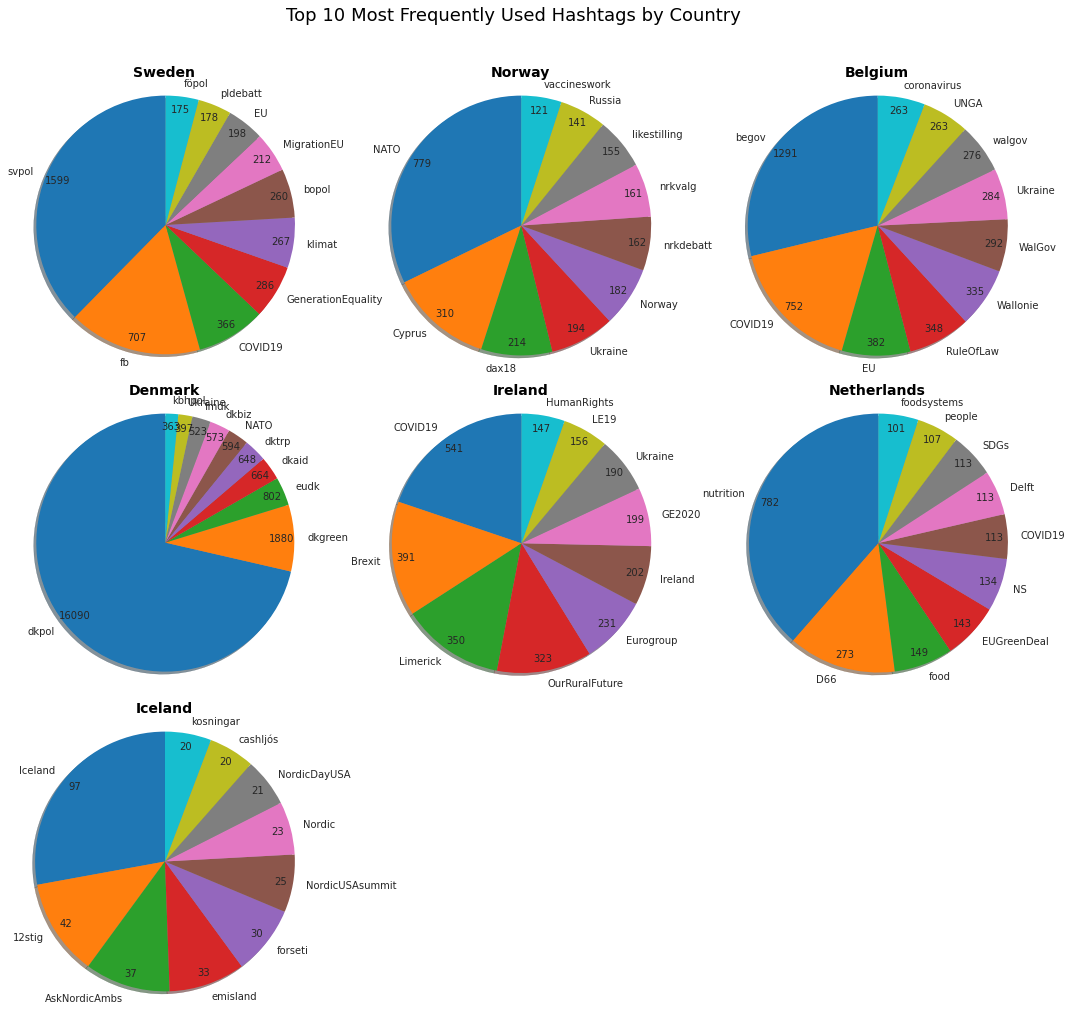

In [15]:
# Get a list of unique countries
country_names = list(frequent_words.keys())

# Calculate the number of rows and columns to use in the plot
columns = 3
rows = int(math.ceil(len(countries)/columns))

# Create the subplot grid
figure, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15, 15))

# Customize the figure
title = "Top 10 Most Frequently Used Hashtags by Country"
figure.suptitle(title, fontsize=18)
plt.style.use("seaborn")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create and customize the subplots
for i in range(rows * columns):

    # Determine what subplot to be plotting on
    current_row, current_column = divmod(i, rows)

    # Turn off any extraneous subplots
    if i >= len(country_names):
        axes[current_row][current_column].axis("off")
        continue

    # Extract information about the country
    country_name = country_names[i]
    country_info = frequent_words[country_name]
    labels, sizes = list(zip(*country_info))

    # Create the pie chart and plot on the appropriate axis
    axes[current_row][current_column].pie(
        sizes, labels=labels,
        autopct=lambda p: "{:.0f}".format(p * sum(sizes) / 100),
        pctdistance=0.9, shadow=True, startangle=90,
    )

    # Customize the chart
    axes[current_row][current_column].set_title(
        country_name.capitalize(), fontsize=14, fontweight="bold",
    )
    axes[current_row][current_column].axis("equal")

# Show the plot
plt.show()

### Political views by country

Next, we can determine the percentage of political view associated with each country.

In [16]:
# Compile a list of all unique contries in the dataset
countries = training_df["country_user"].unique().tolist()
views = training_df["pol_spec_user"].unique().tolist()

# Generate the percentage of political views associated with each country
country_views = {}
for country in countries:
    # Filter the dataframe to only include observations of the country
    country_filter = training_df[training_df["country_user"] == country]
    total = country_filter["pol_spec_user"].count()
    # Calculate the percentages of each views for the country
    temporary = []
    for view in views:
        view_filter = country_filter[country_filter["pol_spec_user"] == view]
        temporary.append((view, view_filter["pol_spec_user"].count()/total))
    country_views[country] = temporary

# Print the result
for k, v in country_views.items():
    print(f"{k}: {v}")

sweden: [('Left', 0.48361088448433076), ('Right', 0.23101934059605508), ('Center', 0.2853697749196141), ('Independent', 0.0)]
norway: [('Left', 0.5277251184834123), ('Right', 0.2621271257318093), ('Center', 0.21014775578477837), ('Independent', 0.0)]
belgium: [('Left', 0.3383909358394449), ('Right', 0.4549426902639322), ('Center', 0.2066663738966229), ('Independent', 0.0)]
denmark: [('Left', 0.41122759553601623), ('Right', 0.3294482825257259), ('Center', 0.2593241219382579), ('Independent', 0.0)]
ireland: [('Left', 0.42448867786705624), ('Right', 0.4081218042366691), ('Center', 0.16738951789627465), ('Independent', 0.0)]
netherlands: [('Left', 0.34176915799432356), ('Right', 0.0380794701986755), ('Center', 0.620151371807001), ('Independent', 0.0)]
iceland: [('Left', 0.5829725829725829), ('Right', 0.27169655741084314), ('Center', 0.00041228612657184083), ('Independent', 0.14491857349000206)]


We will now visualize these results using a stacked bar chart.

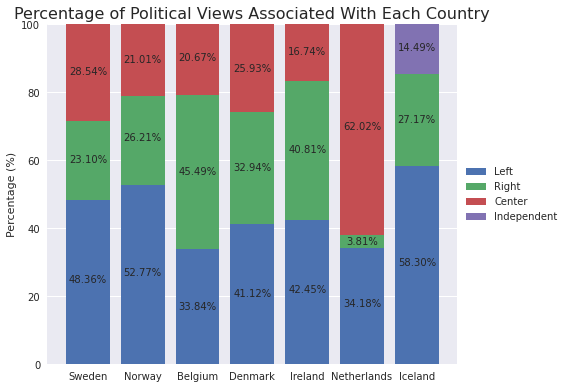

In [17]:
# Restructure the percentage information so it can be plotted
percentages = {view: np.array([]) for view in views}
for country in countries:
    country_info = country_views[country]
    for view, percentage in country_info:
        percentages[view] = np.append(percentages[view], percentage*100)

# Capitalize the country names for aesthetic purposes
capitalized = [country.capitalize() for country in countries]

# Create the figure and axis
figure, axis = plt.subplots()

# Create the stacked bar chart
cumulative = np.zeros(len(capitalized))
for view in percentages:
    percentage = percentages[view]
    # Add value labels to each bar segment
    for i in range(len(capitalized)):
        text_y = percentage[i]//2+cumulative[i]
        if percentage[i] > 3.5:
            plt.text(i, text_y, f"{percentage[i]:0.2f}%", ha="center")
    # Create the bar chart for the current segment
    axis.bar(capitalized, percentage, bottom=cumulative, label=view)
    # Keep track of cumulative sum of bottom bars
    cumulative = np.add(cumulative, percentage)

# Customize the plot
title = "Percentage of Political Views Associated With Each Country"
axis.set_title(title, fontsize=16)
axis.set_ylabel("Percentage (%)")
axis.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

# Show the plot
plt.show()

### Distribution of genders by country

We will now determine the distribution of genders by country.

In [18]:
# Compile a list of all unique contries in the dataset
countries = training_df["country_user"].unique().tolist()
genders = training_df["gender_user"].unique().tolist()

# Generate the percentage of genders associated with each country
country_genders = {}
for country in countries:
    # Filter the dataframe to only include observations of the country
    country_filter = training_df[training_df["country_user"] == country]
    total = country_filter["gender_user"].count()
    # Calculate the percentages of each views for the country
    temporary = []
    for gender in genders:
        gender_filter = country_filter[country_filter["gender_user"] == gender]
        temporary.append((gender, gender_filter["gender_user"].count()/total))
    country_genders[country] = temporary

# Print the result
for k, v in country_genders.items():
    print(f"{k}: {v}")

sweden: [('Male', 0.43144406584441136), ('Female', 0.5685559341555886)]
norway: [('Male', 0.6850850292723725), ('Female', 0.31491497072762753)]
belgium: [('Male', 0.8186838522682359), ('Female', 0.18131614773176408)]
denmark: [('Male', 0.6054398763225276), ('Female', 0.39456012367747234)]
ireland: [('Male', 0.7888285244704164), ('Female', 0.21117147552958362)]
netherlands: [('Male', 0.7711515069604), ('Female', 0.22884849303959995)]
iceland: [('Male', 0.5433931148216863), ('Female', 0.45660688517831377)]


We will now visualize these results using a stacked bar chart.

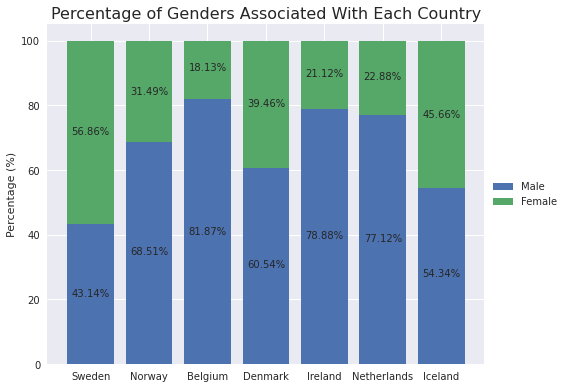

In [19]:
# Restructure the percentage information so it can be plotted
percentages = {gender: np.array([]) for gender in genders}
for country in countries:
    country_info = country_genders[country]
    for gender, percentage in country_info:
        percentages[gender] = np.append(percentages[gender], percentage*100)

# Capitalize the country names for aesthetic purposes
capitalized = [country.capitalize() for country in countries]

# Create the figure and axis
figure, axis = plt.subplots()

# Create the stacked bar chart
cumulative = np.zeros(len(capitalized))
for gender in percentages:
    percentage = percentages[gender]
    # Add value labels to each bar segment
    for i in range(len(capitalized)):
        text_y = percentage[i]//2+cumulative[i]
        if percentage[i] > 3.5:
            plt.text(i, text_y, f"{percentage[i]:0.2f}%", ha="center")
    # Create the bar chart for the current segment
    axis.bar(capitalized, percentage, bottom=cumulative, label=gender)
    # Keep track of cumulative sum of bottom bars
    cumulative = np.add(cumulative, percentage)

# Customize the plot
title = "Percentage of Genders Associated With Each Country"
axis.set_title(title, fontsize=16)
axis.set_ylabel("Percentage (%)")
axis.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Show the plot
plt.tight_layout()
plt.show()

## Natural language processing

### Cleaning and lemmatizing the tweets

It is also apparent that the *full_text* column contains information regarding whether or not the tweet is a retweet, and if it is, who it is retweeting.

We will first extract the retweeted user from the tweets using `get_retweeted_user` and store this information in a new column.

Next, we will remove this information from the tweet using `remove_retweet` since it presumably is not be part of the tweet, and should not be counted in any character or word counts.

In [20]:
def get_retweeted_user(text: str) -> Optional[str]:
    """Gets the username of the user that is being retweeted."""

    retweet_search = re.search(r"^b['\"](RT @(.*?): )?([\s\S]*)['\"]$", text)
    if not retweet_search or not retweet_search.group(1):
        return np.nan
    return retweet_search.group(2)

def remove_retweet(text: str) -> str:
    """Removes the retweet descriptor if it appears in the text."""

    retweet_search = re.search(r"^b['\"](RT @(.*?): )?([\s\S]*)['\"]$", text)
    # return retweet_search.group(3)
    return f"b'{retweet_search.group(3)}'"

In [21]:
training_df["retweeted_user"] = training_df["full_text"].apply(get_retweeted_user)
training_df["is_retweet"] = training_df["retweeted_user"].notnull()*1
training_df["text_clean"] = training_df["full_text"].apply(remove_retweet)
training_df.head()

,hashtags,full_text,in_reply_to_screen_name,country_user,gender_user,pol_spec_user,text_words,text_chars,hashtags_words,hashtags_chars,retweeted_user,is_retweet,text_clean
0,feminist AskMeAnything,b'RT @swedennewyork: What does it mean to have...,NaN,sweden,Male,Left,25,154,2,22,swedennewyork,1,b'What does it mean to have a #feminist govern...
1,,b'Jens Stoltenberg \xc3\xa5pnet virtuelle Rock...,NaN,norway,Male,Left,13,107,0,0,NaN,0,b'Jens Stoltenberg \xc3\xa5pnet virtuelle Rock...
2,,b'@Panenka_Bart Veel beterschap Bart en Loes! ...,BartDerwael,belgium,Male,Left,7,63,0,0,NaN,0,b'@Panenka_Bart Veel beterschap Bart en Loes! ...
3,,b'RT @CarlEmilLind: Tydelige S aftryk: \n\nPsk...,NaN,denmark,Female,Left,15,179,0,0,CarlEmilLind,1,b'Tydelige S aftryk: \n\nPskykiatrien styrkes\...
4,,b'\xf0\x9f\x98\x83 https://t.co/bpqoZ8Y4wm',NaN,sweden,Male,Left,2,43,0,0,NaN,0,b'\xf0\x9f\x98\x83 https://t.co/bpqoZ8Y4wm'


Below is the contents of the provided Python file, `lemmatizer.py`, with some minor modifications to clean up comments, make it work with Python 3, etc.

In [22]:
lemmatizer = WordNetLemmatizer()

def nltk_tag_to_wordnet_tag(nltk_tag):
    """Tags the words in the tweets."""

    if nltk_tag.startswith('J'):
        return wn.ADJ
    elif nltk_tag.startswith('V'):
        return wn.VERB
    elif nltk_tag.startswith('N'):
        return wn.NOUN
    elif nltk_tag.startswith('R'):
        return wn.ADV
    return None

def lemmatize_tweet(tweet):
    """
    Lemmatizes the words in tweets and returns the cleaned and lemmatized tweet.
    """

    # Tokenize the tweet and find the POS tag for each token
    tweet = tweet_cleaner(tweet)
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(tweet))
    # Tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_tweet = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # If there is no available tag, append the token as is
            lemmatized_tweet.append(word)
        else:
            # Otherwise, use the tag to lemmatize the token
            lemmatized_tweet.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_tweet)

Below is the `tweet_cleaner` function as well as the code that supports it. The helper code is comprised of things like a set of stopwords and the `remove_urls` function (which obviously removes URLs from a string).

It was clear that the tweets were originally stored as byte strings given that they are wrapped with `b"..."`. This wrapping will be removed. This will be done using the `decode_string` function.

We also need to convert the unicode/special characters into emojis so that we could remove them using the `emoji` module. This will also be done using the `decode_string` function.

Lastly, we decided to remove HTML entities using `html.unescape` just in case any tweets contained entities such as `&amp;` (corresponds to *&amp;*) or `&lt;` (corresponds to *&lt;*). The full list of HTML entities can be found [here](https://www.freeformatter.com/html-entities.html).

In [23]:
STOPWORDS = set(stopwords.words("english"))
languages = ["danish", "dutch", "french", "german", "swedish", "norwegian"]
for language in languages:
    STOPWORDS.update(stopwords.words(language))

In [24]:
def remove_urls(text: str, replacement: str="") -> str:
    """Removes URLs from a given string."""
    
    # Define the regex used to identify URLs
    URL_EXPRESSION = (
        r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)"
        r"(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s("
        r")<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    )
    # Replace any URLs with the replacement string
    return re.sub(URL_EXPRESSION, replacement, text)

In [25]:
def decode_string(string: str) -> str:
    """Decode the string for more accurate character and word measurements."""

    # Remove the byte string annotations (b'...')
    inner_string = re.search(r"^(b')?(.*?)(')?$", string).group(2)

    # Unicode escape the string
    unicode_escaped = inner_string.encode().decode("unicode_escape")

    # Raw unicode escape the string
    raw_unicode_escaped = unicode_escaped.encode("raw_unicode_escape").decode()

    # Return the fully decoded string
    return raw_unicode_escaped

In [26]:
def tweet_cleaner(tweet: str) -> str:
    """Cleans the given tweet.
    
    Performs the following operations:
    - Removes stopwords
    - Removes words shorter than 3 characters
    - Removes links
    - Removes emojis
    - Removes punctuation
    - Removes HTML entities
    - Removes digits
    """

    # Remove random unicode that was prevalent in the data
    tweet = tweet.replace("\u2066", "")
    
    # Replace emojis with an empty string
    tweet = decode_string(tweet)
    tweet = emoji.replace_emoji(tweet, replace="")

    # Remove URLs
    tweet = remove_urls(tweet)

    # Remove punctuation
    table = str.maketrans(dict.fromkeys(string.punctuation))
    tweet = tweet.translate(table)

    # Strip whitespace from both ends of the tweet
    tweet = tweet.strip()

    # Remove words shorter than 3 characters and check for uncaught links
    words_to_keep = []
    for word in tweet.split(" "):
        if (len(word) >= 3) and (word not in STOPWORDS) and \
                (not word.startswith("http")):
            words_to_keep.append(word)
    tweet = " ".join(words_to_keep)

    # Remove HTML entities
    tweet = html.unescape(tweet)
    
    # Remove digits and other punctuation from string
    tweet = re.sub(r"[0-9…‘’]+", "", tweet)

    # Return the cleaned tweet
    return tweet

We will now apply the `lemmatize_tweet` function to the *full_text* column, and store the output in a new column: *text_clean*.

In [27]:
training_df["text_clean"] = training_df["text_clean"].apply(lemmatize_tweet)
training_df.head()

,hashtags,full_text,in_reply_to_screen_name,country_user,gender_user,pol_spec_user,text_words,text_chars,hashtags_words,hashtags_chars,retweeted_user,is_retweet,text_clean
0,feminist AskMeAnything,b'RT @swedennewyork: What does it mean to have...,NaN,sweden,Male,Left,25,154,2,22,swedennewyork,1,What mean feminist government Join reddit EST ...
1,,b'Jens Stoltenberg \xc3\xa5pnet virtuelle Rock...,NaN,norway,Male,Left,13,107,0,0,NaN,0,Jens Stoltenberg åpnet virtuelle Rockheim dag ...
2,,b'@Panenka_Bart Veel beterschap Bart en Loes! ...,BartDerwael,belgium,Male,Left,7,63,0,0,NaN,0,PanenkaBart Veel beterschap Bart Loes
3,,b'RT @CarlEmilLind: Tydelige S aftryk: \n\nPsk...,NaN,denmark,Female,Left,15,179,0,0,CarlEmilLind,1,Tydelige aftryk Pskykiatrien styrkes CO redukt...
4,,b'\xf0\x9f\x98\x83 https://t.co/bpqoZ8Y4wm',NaN,sweden,Male,Left,2,43,0,0,NaN,0,


Like with previous exploration steps, we will count the number of words and characters in the *text_clean* column. This information will then be stored in new columns.

In [28]:
training_df["clean_words"] = training_df["text_clean"].apply(count_words)
training_df["clean_chars"] = training_df["text_clean"].apply(count_characters)
training_df.head()

,hashtags,full_text,in_reply_to_screen_name,country_user,gender_user,pol_spec_user,text_words,text_chars,hashtags_words,hashtags_chars,retweeted_user,is_retweet,text_clean,clean_words,clean_chars
0,feminist AskMeAnything,b'RT @swedennewyork: What does it mean to have...,NaN,sweden,Male,Left,25,154,2,22,swedennewyork,1,What mean feminist government Join reddit EST ...,10,69
1,,b'Jens Stoltenberg \xc3\xa5pnet virtuelle Rock...,NaN,norway,Male,Left,13,107,0,0,NaN,0,Jens Stoltenberg åpnet virtuelle Rockheim dag ...,7,51
2,,b'@Panenka_Bart Veel beterschap Bart en Loes! ...,BartDerwael,belgium,Male,Left,7,63,0,0,NaN,0,PanenkaBart Veel beterschap Bart Loes,5,37
3,,b'RT @CarlEmilLind: Tydelige S aftryk: \n\nPsk...,NaN,denmark,Female,Left,15,179,0,0,CarlEmilLind,1,Tydelige aftryk Pskykiatrien styrkes CO redukt...,10,99
4,,b'\xf0\x9f\x98\x83 https://t.co/bpqoZ8Y4wm',NaN,sweden,Male,Left,2,43,0,0,NaN,0,,0,0


We now calculate the minimum, maximum, average, and median values of the word and characters counts. The results of these calculations are then appended to the previous aggregate summary table.

In [29]:
# Minimum characters and words of tweets
min_clean_chars = training_df["clean_chars"].min()
min_clean_words = training_df["clean_words"].min()
# Maximum characters and words of tweets
max_clean_chars = training_df["clean_chars"].max()
max_clean_words = training_df["clean_words"].max()
# Average characters and words of tweets
ave_clean_chars = training_df["clean_chars"].mean()
ave_clean_words = training_df["clean_words"].mean()
# Median characters and words of tweets
med_clean_chars = training_df["clean_chars"].median()
med_clean_words = training_df["clean_words"].median()

In [30]:
# Create the aggregate summary table
table = [
    ["",                   "",           "Minimum",         "Maximum",         "Average",         "Median"         ],
    ["Tweets (uncleaned)", "Characters", min_tweet_chars,   max_tweet_chars,   ave_tweet_chars,   med_tweet_chars  ],
    ["",                   "Words",      min_tweet_words,   max_tweet_words,   ave_tweet_words,   med_tweet_words  ],
    ["Tweets (cleaned)",   "Characters", min_clean_chars,   max_clean_chars,   ave_clean_chars,   med_clean_chars  ],
    ["",                   "Words",      min_clean_words,   max_clean_words,   ave_clean_words,   med_clean_words  ],
    ["Hashtags",           "Characters", min_hashtag_chars, max_hashtag_chars, ave_hashtag_chars, med_hashtag_chars],
    ["",                   "Words",      min_hashtag_words, max_hashtag_words, ave_hashtag_words, med_hashtag_words],
]
# Print the summary table to the screen
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════════╤════════════╤═══════════╤═══════════╤════════════╤══════════╕
│                    │            │   Minimum │   Maximum │    Average │   Median │
╞════════════════════╪════════════╪═══════════╪═══════════╪════════════╪══════════╡
│ Tweets (uncleaned) │ Characters │         4 │      2994 │ 167.304    │      156 │
├────────────────────┼────────────┼───────────┼───────────┼────────────┼──────────┤
│                    │ Words      │         1 │       102 │  20.2226   │       19 │
├────────────────────┼────────────┼───────────┼───────────┼────────────┼──────────┤
│ Tweets (cleaned)   │ Characters │         0 │       746 │  89.242    │       85 │
├────────────────────┼────────────┼───────────┼───────────┼────────────┼──────────┤
│                    │ Words      │         0 │        77 │  11.4057   │       11 │
├────────────────────┼────────────┼───────────┼───────────┼────────────┼──────────┤
│ Hashtags           │ Characters │         0 │       145 │   4.39559  │    

# Part II: Model Creation and Prediction

## Import and clean test data

In [33]:
path = "test_data.xlsx"
testing_df = pd.read_excel(f"{INPUT_PATH}/{path}")
testing_df.head()

,Id,hashtags,full_text,in_reply_to_screen_name,country_user,gender_user,pol_spec_user
0,0,EUAfrica,"b'RT @eu_eeas: ""Let me tell you that a big par...",NaN,belgium,Male,NaN
1,1,COVID19,"b'RT @stateofgreendk: ""Although the #COVID19 p...",NaN,denmark,Male,NaN
2,2,NaN,b'@hjorvarhaflida // jebb - i\xc3\xb0a\xc3\xb0...,hjorvarhaflida,iceland,Female,NaN
3,3,NaN,"b'I ett l\xc3\xa4ge med pandemi, klimat, trans...",NaN,sweden,Female,NaN
4,4,UNGA ChildrenNotSoldiers,b'RT @BelgiumMFA: \xf0\x9f\x93\x8d #UNGA\n\n\x...,NaN,belgium,Male,NaN


In [34]:
testing_df = testing_df.set_index("Id")

In [35]:
testing_df["hashtags"] = testing_df["hashtags"].astype("string")
testing_df["full_text"] = testing_df["full_text"].astype("string")
testing_df.dtypes

hashtags                    string
full_text                   string
in_reply_to_screen_name     object
country_user                object
gender_user                 object
pol_spec_user              float64
dtype: object

In [36]:
testing_df["hashtags"] = testing_df["hashtags"].replace(np.nan, "", regex=True)

In [37]:
testing_df["retweeted_user"] = testing_df["full_text"].apply(get_retweeted_user)
testing_df["text_clean"] = testing_df["full_text"].apply(remove_retweet)
testing_df["text_clean"] = testing_df["text_clean"].apply(lemmatize_tweet)
testing_df.head()

,hashtags,full_text,in_reply_to_screen_name,country_user,gender_user,pol_spec_user,retweeted_user,text_clean
Id,,,,,,,,
0,EUAfrica,"b'RT @eu_eeas: ""Let me tell you that a big par...",NaN,belgium,Male,NaN,eu_eeas,Let tell big part worlds future present depend...
1,COVID19,"b'RT @stateofgreendk: ""Although the #COVID19 p...",NaN,denmark,Male,NaN,stateofgreendk,Although COVID pandemic overshadows daily life...
2,,b'@hjorvarhaflida // jebb - i\xc3\xb0a\xc3\xb0...,hjorvarhaflida,iceland,Female,NaN,NaN,hjorvarhaflida jebb iðaði meðan beið
3,,"b'I ett l\xc3\xa4ge med pandemi, klimat, trans...",NaN,sweden,Female,NaN,NaN,läge pandemi klimat transportvital teknik ekon...
4,UNGA ChildrenNotSoldiers,b'RT @BelgiumMFA: \xf0\x9f\x93\x8d #UNGA\n\n\x...,NaN,belgium,Male,NaN,BelgiumMFA,UNGA Every child deserve safe childhood Follow...


## Save and load pickle files

Pickle files are specifically useful here so that we don't have to rerun the previous code everytime I want to reverse changes.

In [38]:
training_df.to_pickle(f"{OUTPUT_PATH}/training_df_clean.pkl")
testing_df.to_pickle(f"{OUTPUT_PATH}/testing_df_clean.pkl")

In [39]:
training_df = pd.read_pickle(f"{OUTPUT_PATH}/training_df_clean.pkl")
testing_df = pd.read_pickle(f"{OUTPUT_PATH}/testing_df_clean.pkl")

## Create a new column

In [40]:
for column in ["retweeted_user", "in_reply_to_screen_name"]:
    training_df[column] = training_df[column].replace(np.nan, "", regex=True)
    testing_df[column] = testing_df[column].replace(np.nan, "", regex=True)

In [41]:
columns_to_join = [ # order matters
    "gender_user",
    "country_user",
    "hashtags",
    "retweeted_user",
    "in_reply_to_screen_name",
    "text_clean",
]
training_df['processed_text'] = training_df[columns_to_join].agg(" ".join, axis=1)
testing_df['processed_text'] = testing_df[columns_to_join].agg(" ".join, axis=1)

In [42]:
training_df.head()

,hashtags,full_text,in_reply_to_screen_name,country_user,gender_user,pol_spec_user,text_words,text_chars,hashtags_words,hashtags_chars,retweeted_user,is_retweet,text_clean,clean_words,clean_chars,processed_text
0,feminist AskMeAnything,b'RT @swedennewyork: What does it mean to have...,,sweden,Male,Left,25,154,2,22,swedennewyork,1,What mean feminist government Join reddit EST ...,10,69,Male sweden feminist AskMeAnything swedennewyo...
1,,b'Jens Stoltenberg \xc3\xa5pnet virtuelle Rock...,,norway,Male,Left,13,107,0,0,,0,Jens Stoltenberg åpnet virtuelle Rockheim dag ...,7,51,Male norway Jens Stoltenberg åpnet virtuell...
2,,b'@Panenka_Bart Veel beterschap Bart en Loes! ...,BartDerwael,belgium,Male,Left,7,63,0,0,,0,PanenkaBart Veel beterschap Bart Loes,5,37,Male belgium BartDerwael PanenkaBart Veel be...
3,,b'RT @CarlEmilLind: Tydelige S aftryk: \n\nPsk...,,denmark,Female,Left,15,179,0,0,CarlEmilLind,1,Tydelige aftryk Pskykiatrien styrkes CO redukt...,10,99,Female denmark CarlEmilLind Tydelige aftryk ...
4,,b'\xf0\x9f\x98\x83 https://t.co/bpqoZ8Y4wm',,sweden,Male,Left,2,43,0,0,,0,,0,0,Male sweden


## Split into training and validation datasets

In [43]:
X = training_df["processed_text"].astype("string")
y = training_df["pol_spec_user"].astype("string")

X_test = testing_df["processed_text"]

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=0)

In [45]:
print(f"Training set:")
print(f"\tX: {X_train.shape[0]} rows")
print(f"\ty: {y_train.shape[0]} rows")

print(f"Validation set:")
print(f"\tX: {X_val.shape[0]} rows")
print(f"\ty: {y_val.shape[0]} rows")

Training set:
	X: 346139 rows
	y: 346139 rows
Validation set:
	X: 61084 rows
	y: 61084 rows


## Logistic regression pipeline

In [46]:
# Specify the maximum number of features to use
N_FEATURES = 1_000_000

# Create the pipeline and fit the training data
pipe = Pipeline([
    ("Count Vectorizer", CountVectorizer(max_features=N_FEATURES, ngram_range=(1, 3))),
    ("Tfidf Transformer", TfidfTransformer()),
    ("Logistic Regression", LogisticRegression(solver="saga", random_state=0, n_jobs=-1, verbose=3)),
])
pipe.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.18315807
Epoch 3, change: 0.08136481
Epoch 4, change: 0.05355887
Epoch 5, change: 0.04856522
Epoch 6, change: 0.04329057
Epoch 7, change: 0.04479249
Epoch 8, change: 0.03370969
Epoch 9, change: 0.02506093
Epoch 10, change: 0.02630448
Epoch 11, change: 0.01589793
Epoch 12, change: 0.01072342
Epoch 13, change: 0.00544224
Epoch 14, change: 0.00704669
Epoch 15, change: 0.00468387
Epoch 16, change: 0.00626166
Epoch 17, change: 0.00234629
Epoch 18, change: 0.00140966
Epoch 19, change: 0.00197619
Epoch 20, change: 0.00075346
Epoch 21, change: 0.00063728
Epoch 22, change: 0.00049975
Epoch 23, change: 0.00032097
Epoch 24, change: 0.00022950
Epoch 25, change: 0.00012596
convergence after 26 epochs took 34 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   33.9s finished


Pipeline(steps=[('Count Vectorizer',
                 CountVectorizer(max_features=1000000, ngram_range=(1, 3))),
                ('Tfidf Transformer', TfidfTransformer()),
                ('Logistic Regression',
                 LogisticRegression(n_jobs=-1, random_state=0, solver='saga',
                                    verbose=3))])

In [47]:
score = pipe.score(X_val, y_val)
print(f"{score*100:.2f}% accuracy on the validation dataset.")

77.97% accuracy on the validation dataset.


## Confusion matrix

In [48]:
y_pred = pipe.predict(X_val)

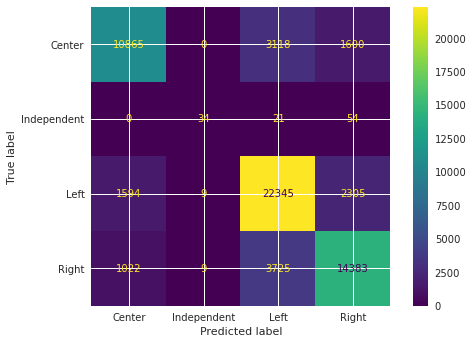

In [49]:
matrix = confusion_matrix(y_val, y_pred)
display = ConfusionMatrixDisplay(matrix, display_labels=pipe.classes_)
display.plot()

## Make predictions using the test data

In [50]:
prediction = pipe.predict(X_test)
prediction_df = pd.DataFrame({"Id": range(len(prediction)), "pol_spec_user": prediction})
prediction_df.head()

,Id,pol_spec_user
0,0,Left
1,1,Left
2,2,Left
3,3,Left
4,4,Right


Next, we can show the class distribution of the prediction.

In [51]:
total = len(prediction_df)
left = len(prediction_df[prediction_df["pol_spec_user"]=="Left"]) / total
right = len(prediction_df[prediction_df["pol_spec_user"]=="Right"]) / total
center = len(prediction_df[prediction_df["pol_spec_user"]=="Center"]) / total
independent = len(prediction_df[prediction_df["pol_spec_user"]=="Independent"]) / total

padding = len("Independent:")

print(f"Distribution of predicted political views:")
print(f"\t{'Left:':<{padding}} {left*100:>5.2f}%")
print(f"\t{'Right:':<{padding}} {right*100:>5.2f}%")
print(f"\t{'Center:':<{padding}} {center*100:>5.2f}%")
print(f"\t{'Independent:':<{padding}} {independent*100:>5.2f}%")

Distribution of predicted political views:
	Left:        47.61%
	Right:       30.12%
	Center:      22.17%
	Independent:  0.10%


Finally, we can save the prediction as a CSV file--ready for submission.

In [52]:
prediction_df.to_csv(f"{OUTPUT_PATH}/prediction.csv", index=False)